### Imports

In [1]:
import os,json, numpy as np, matplotlib.pyplot as plt
import spectral as sp

from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, closing, footprint_rectangle
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from skimage.draw import line
from scipy.signal import find_peaks

### Global Parameters

In [ ]:
# File (change to one of your .hdr paths)
HDR = "data/TKAL04B-2_SWIR_384_SN3151_4000us_2025-08-27T151141_raw_rad_float32.hdr"

# Parameters
WHITE_PATCH_HALF = 20   # 20 => 40x40 patch around center of white panel
EPS = 1e-6
SAVE_DIR = "results"
os.makedirs(SAVE_DIR, exist_ok=True)

### Load cube + wavelengths

In [ ]:
# Load hyperspectral cube
img = sp.envi.open(HDR)
cube = img.load().astype(np.float32)
H, W, B = cube.shape
print("Cube shape:", cube.shape)

# Try to read wavelengths
try:
    wavs = np.array([float(w) for w in img.bands.centers])
    print("Wavelengths available:", wavs[:5], "...", wavs[-5:])
except Exception as e:
    wavs = None
    print("No wavelengths found in header:", e)

Cube shape: (2230, 384, 288)
Wavelengths available: [953.306751 958.750854 964.194958 969.639061 975.083165] ... [2493.988055 2499.432158 2504.876262 2510.320365 2515.764469]


### Build luminance image & visualize (for white-panel search)

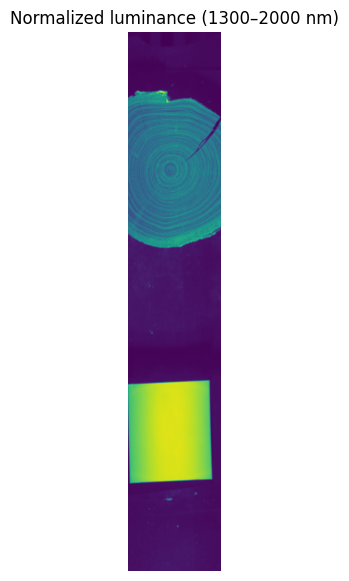

In [4]:
# Use mid–high SWIR (1300–2000 nm) to reduce wood texture and emphasize the white panel
mask_sw = (wavs >= 1300) & (wavs <= 2000)
if mask_sw.sum() < 10:
    mask_sw = np.ones(B, dtype=bool)  # fallback

lum = cube[:, :, mask_sw].mean(axis=2)
lumN = (lum - np.nanmin(lum)) / (np.nanmax(lum) - np.nanmin(lum) + 1e-9)

plt.figure(figsize=(5,7))
plt.imshow(lumN, vmin=0, vmax=1)
plt.title("Normalized luminance (1300–2000 nm)")
plt.axis("off")
plt.show()


### Threshold, pick the best bright region, and define a center patch

Candidate bright regions: 1


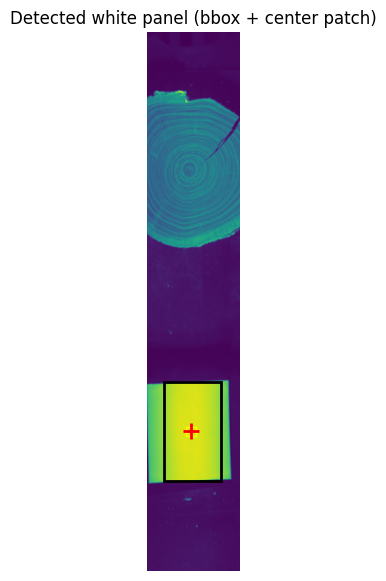

Panel bbox: (1447, 71, 1858, 304) center: (1652, 183) patch: (1632, 1672, 163, 203)


In [5]:
# Threshold (push toward very bright to avoid wood highlights)
t = threshold_otsu(lumN)
bw = lumN > max(t, 0.85)
bw = closing(bw, footprint_rectangle((5, 5)))
bw = remove_small_objects(bw, min_size=2000)

lab = label(bw)
regions = regionprops(lab)
print("Candidate bright regions:", len(regions))

if not regions:
    raise RuntimeError("No bright region found for white panel; tweak threshold or choose manual ROI.")

# Choose region with highest mean luminance + slight bias to bottom (common placement)
best = None
best_score = -1.0
H, W, B = cube.shape
for r in regions:
    minr, minc, maxr, maxc = r.bbox
    area = (maxr-minr)*(maxc-minc)
    if area < 3000:
        continue
    mean_val = lumN[minr:maxr, minc:maxc].mean()
    score = mean_val + 0.1*(r.centroid[0]/H)
    if score > best_score:
        best_score, best = score, r

minr, minc, maxr, maxc = best.bbox
cy, cx = map(int, best.centroid)

WHITE_PATCH_HALF = 20  # 40x40 patch; adjust if needed
r0, r1 = max(0, cy-WHITE_PATCH_HALF), min(H, cy+WHITE_PATCH_HALF)
c0, c1 = max(0, cx-WHITE_PATCH_HALF), min(W, cx+WHITE_PATCH_HALF)

plt.figure(figsize=(5,7))
plt.imshow(lumN, vmin=0, vmax=1)
plt.title("Detected white panel (bbox + center patch)")
import matplotlib.patches as patches
ax = plt.gca()
ax.add_patch(patches.Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, lw=2))
ax.add_patch(patches.Rectangle((c0, r0), c1-c0, r1-r0, fill=False, color='yellow'))
ax.plot(cx, cy, 'r+', ms=12, mew=2)
plt.axis("off")
plt.show()

print("Panel bbox:", (minr, minc, maxr, maxc), "center:", (cy, cx), "patch:", (r0, r1, c0, c1))


### Compute the white spectrum from that center patch

White patch shape: (40, 40, 288)
Wspec stats — min/max/median: 0.043271053582429886 0.22592054307460785 0.1328592300415039


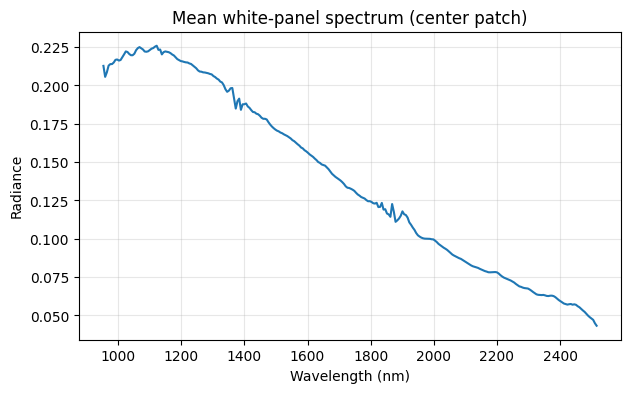

In [6]:
# Cell 5 — White spectrum from panel center patch
white_patch = cube[r0:r1, c0:c1, :]            # (h, w, B)
Wspec = np.nanmean(white_patch.reshape(-1, B), axis=0)

print("White patch shape:", white_patch.shape)
print("Wspec stats — min/max/median:",
      float(np.nanmin(Wspec)),
      float(np.nanmax(Wspec)),
      float(np.nanmedian(Wspec)))

plt.figure(figsize=(7,4))
plt.plot(wavs, Wspec)
plt.title("Mean white-panel spectrum (center patch)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radiance")
plt.grid(True, alpha=0.3)
plt.show()

### Apply white correction + (optional) saturation mask

In [7]:
# Cell 6 — Apply white correction (+ optional saturation mask)

# Try to find a matching *_satmask.hdr file
satmask_path = HDR.replace(".hdr", "_satmask.hdr")
sat_any = np.zeros((H, W), dtype=bool)

if os.path.exists(satmask_path):
    sat = sp.envi.open(satmask_path).load()
    # sat can be (H,W), (H,W,1), or (H,W,B)
    if sat.ndim == 3:
        sat_any = (sat > 0).any(axis=2)
    else:
        sat_any = (sat > 0)

# Normalize with white spectrum
EPS = 1e-6
reflect = cube / (Wspec[None, None, :] + EPS)

# Mask saturated pixels across all bands (broadcast via np.where)
reflect = np.where(sat_any[..., None], np.nan, reflect)

# Keep a reasonable range
reflect = np.clip(reflect, 0, 1.5)

print("Reflectance cube:", reflect.shape)
print("Reflectance stats — min/max/median:",
      float(np.nanmin(reflect)),
      float(np.nanmax(reflect)),
      float(np.nanmedian(reflect)))
print("Saturation mask — shape:", sat_any.shape, "true count:", int(sat_any.sum()))


Reflectance cube: (2230, 384, 288)
Reflectance stats — min/max/median: 0.0 1.5 0.06413397938013077
Saturation mask — shape: (2230, 384) true count: 0


### False-color comparison (raw vs reflectance)

Bands used (nm): [1699.1, 1448.7, 1100.3] indices: [137, 91, 27]


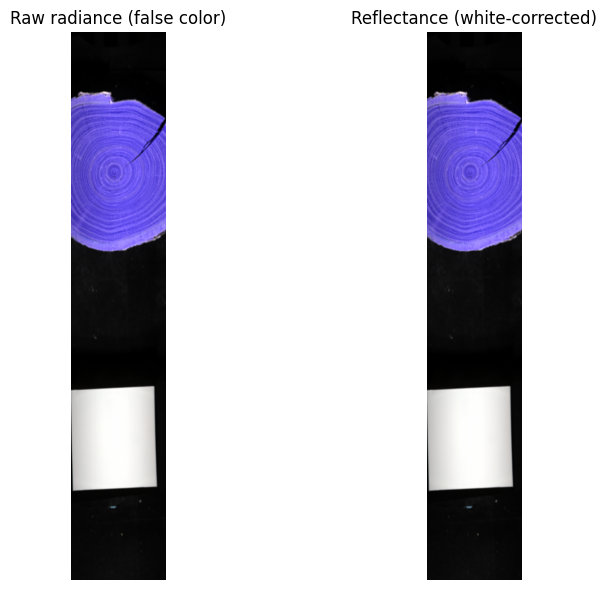

In [8]:
# Cell 7 — False-color before/after

def pick_bands_by_nm(w, targets_nm):
    return [int(np.argmin(np.abs(w - t))) for t in targets_nm]

# You can tweak these wavelengths later for best contrast on rings
bands_rgb = pick_bands_by_nm(wavs, [1700, 1450, 1100])
print("Bands used (nm):", [round(wavs[i],1) for i in bands_rgb], "indices:", bands_rgb)

def make_rgb(arr, bands):
    sub = arr[:, :, bands].astype(np.float32).copy()
    rgb = np.empty_like(sub)
    for k in range(3):
        ch = sub[:, :, k]
        vmin = np.nanpercentile(ch, 2)
        vmax = np.nanpercentile(ch, 98)
        rgb[:, :, k] = (ch - vmin) / (vmax - vmin + 1e-9)
    return np.clip(rgb, 0, 1)

rgb_raw = make_rgb(cube, bands_rgb)
rgb_ref = make_rgb(reflect, bands_rgb)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1); plt.imshow(rgb_raw); plt.title("Raw radiance (false color)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rgb_ref); plt.title("Reflectance (white-corrected)"); plt.axis("off")
plt.tight_layout()
plt.show()


### Ring-enhancement indices

Band indices: 45 143 211 253
Band wavelengths: 1198.29141 1731.813558 2102.012599 2330.664948


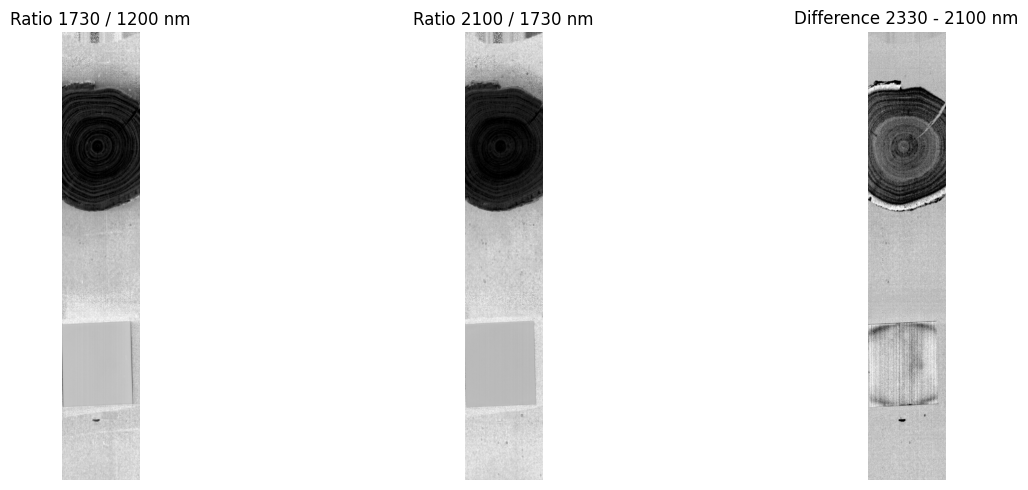

In [9]:
# Pick bands of interest by wavelength
b1200 = int(np.argmin(np.abs(wavs - 1200)))
b1730 = int(np.argmin(np.abs(wavs - 1730)))
b2100 = int(np.argmin(np.abs(wavs - 2100)))
b2330 = int(np.argmin(np.abs(wavs - 2330)))

print("Band indices:", b1200, b1730, b2100, b2330)
print("Band wavelengths:", wavs[b1200], wavs[b1730], wavs[b2100], wavs[b2330])

# Band ratio maps
ratio_1730_1200 = reflect[:, :, b1730] / (reflect[:, :, b1200] + EPS)
ratio_2100_1730 = reflect[:, :, b2100] / (reflect[:, :, b1730] + EPS)
diff_2330_2100 = reflect[:, :, b2330] - reflect[:, :, b2100]

# Normalize each for visualization
def norm_img(img):
    vmin, vmax = np.nanpercentile(img, 2), np.nanpercentile(img, 98)
    return np.clip((img - vmin) / (vmax - vmin + 1e-9), 0, 1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(norm_img(ratio_1730_1200), cmap="gray"); plt.title("Ratio 1730 / 1200 nm"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(norm_img(ratio_2100_1730), cmap="gray"); plt.title("Ratio 2100 / 1730 nm"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(norm_img(diff_2330_2100), cmap="gray"); plt.title("Difference 2330 - 2100 nm"); plt.axis("off")
plt.tight_layout()
plt.show()


### Edge enhancement (Sobel + Laplacian of Gaussian)

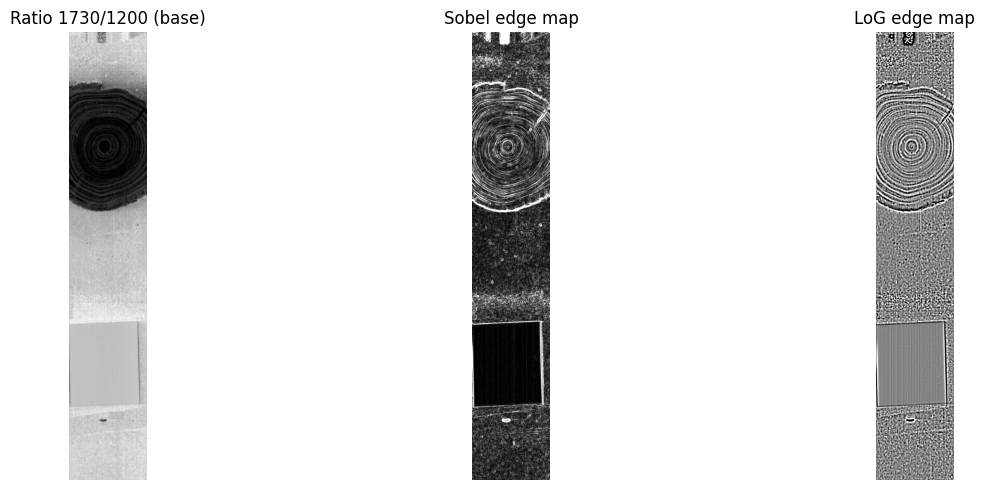

In [10]:
from skimage.filters import sobel, gaussian, laplace

# Choose the best ratio map (1730/1200)
ring_map = ratio_1730_1200.copy()

# Smooth a bit to suppress noise
smooth = gaussian(ring_map, sigma=2, preserve_range=True)

# Sobel edges
edges_sobel = sobel(smooth)

# Laplacian of Gaussian (LoG)
edges_log = laplace(gaussian(ring_map, sigma=3))

# Normalize for display
def norm_img(img):
    vmin, vmax = np.nanpercentile(img, 2), np.nanpercentile(img, 98)
    return np.clip((img - vmin) / (vmax - vmin + 1e-9), 0, 1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(norm_img(ring_map), cmap="gray"); plt.title("Ratio 1730/1200 (base)"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(norm_img(edges_sobel), cmap="gray"); plt.title("Sobel edge map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(norm_img(edges_log), cmap="gray"); plt.title("LoG edge map"); plt.axis("off")
plt.tight_layout()
plt.show()


### Radial intensity profile from LoG map

Approx center: 1115 192


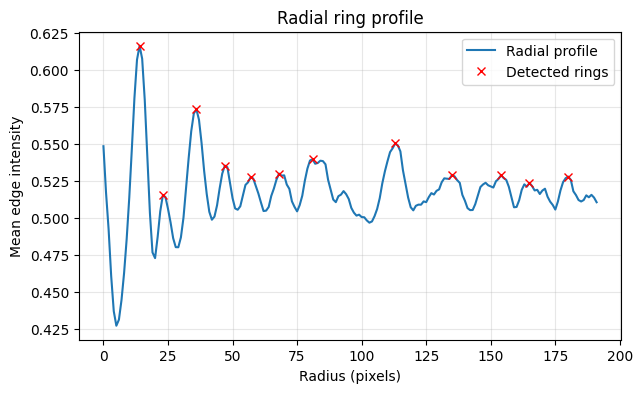

Detected ring count: 12


In [11]:
# Choose LoG edge map as base
ring_img = norm_img(edges_log)

# Approximate wood center (from earlier detection) — we can refine
center_y, center_x = ring_img.shape[0]//2, ring_img.shape[1]//2
print("Approx center:", center_y, center_x)

# Extract radial profile (average intensity along multiple rays)
num_angles = 360
max_radius = min(center_y, center_x, ring_img.shape[0]-center_y, ring_img.shape[1]-center_x)

r_profile = np.zeros(max_radius)
for angle in np.linspace(0, 2*np.pi, num_angles, endpoint=False):
    for r in range(max_radius):
        y = int(center_y + r*np.sin(angle))
        x = int(center_x + r*np.cos(angle))
        if 0 <= y < ring_img.shape[0] and 0 <= x < ring_img.shape[1]:
            r_profile[r] += ring_img[y, x]
r_profile /= num_angles

# Peak detection = ring boundaries
peaks, _ = find_peaks(r_profile, distance=5, prominence=0.01)

plt.figure(figsize=(7,4))
plt.plot(r_profile, label="Radial profile")
plt.plot(peaks, r_profile[peaks], "rx", label="Detected rings")
plt.xlabel("Radius (pixels)")
plt.ylabel("Mean edge intensity")
plt.title("Radial ring profile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Detected ring count:", len(peaks))


Geometric center: (573, 183)
Max radius (px): 183
Detected rings: 13


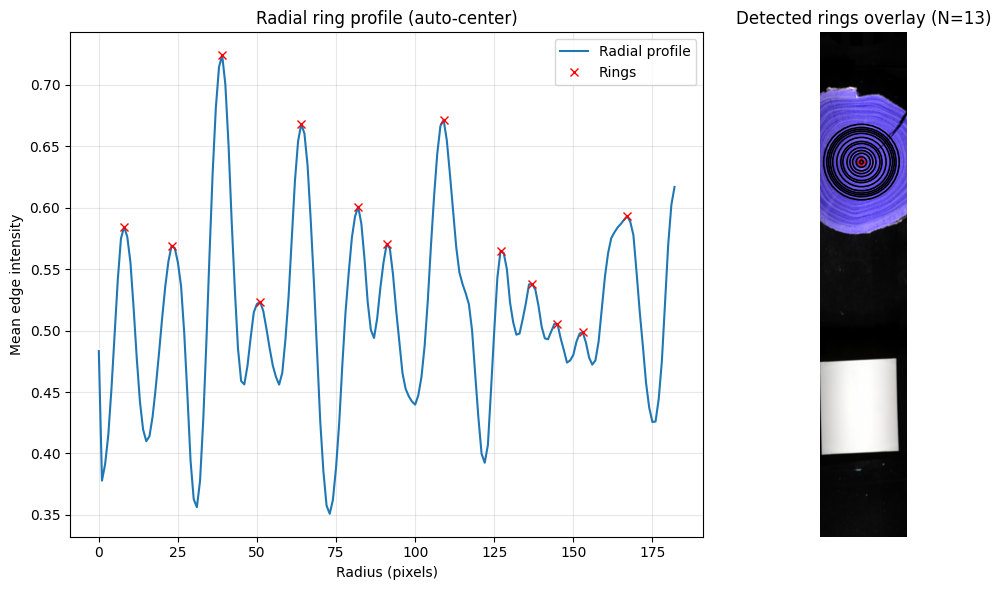

In [12]:
# Cell 11 — Auto center + overlay detected rings on image (bounds-safe)
import numpy as np, matplotlib.pyplot as plt, matplotlib.patches as patches
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects, closing, footprint_rectangle
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from scipy.signal import find_peaks

H, W, B = reflect.shape

# --- 1) Wood mask (use ~1100 nm reflectance, smooth, Otsu) ---
b1100 = int(np.argmin(np.abs(wavs - 1100)))
band_img = reflect[:, :, b1100]
band_s  = gaussian(band_img, sigma=2, preserve_range=True)

t = threshold_otsu(np.nan_to_num(band_s))
wood_mask = band_s > t
wood_mask = closing(wood_mask, footprint_rectangle((5,5)))
wood_mask = remove_small_objects(wood_mask, min_size=5000)
wood_mask = binary_fill_holes(wood_mask)

# Keep largest component
lab = label(wood_mask)
regs = regionprops(lab)
if not regs:
    raise RuntimeError("Wood mask not found — adjust thresholding.")
largest = max(regs, key=lambda r: r.area)
wood_mask = (lab == largest.label)

# --- 2) Geometric center (centroid) ---
cy_g, cx_g = map(int, largest.centroid)
print("Geometric center:", (cy_g, cx_g))

# --- 3) LoG edge base & radial profile (bounds-safe) ---
ring_img = norm_img(edges_log)

# Max usable radius from distance to boundary
dist = distance_transform_edt(wood_mask)
max_radius = int(dist[cy_g, cx_g])

# Also cap by image bounds to avoid x==W or y==H
max_radius = int(min(max_radius, cy_g, cx_g, H-1-cy_g, W-1-cx_g))
print("Max radius (px):", max_radius)

num_angles = 360
r_profile = np.zeros(max_radius, dtype=np.float32)

angles = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
for theta in angles:
    cs, sn = np.cos(theta), np.sin(theta)
    for r in range(max_radius):
        y = int(cy_g + r*sn)
        x = int(cx_g + r*cs)
        # bounds + inside wood check
        if (0 <= y < H) and (0 <= x < W) and wood_mask[y, x]:
            r_profile[r] += ring_img[y, x]
        else:
            break   # stop this ray once it exits the wood
r_profile /= num_angles

# Peak detection = ring boundaries
peaks, _ = find_peaks(r_profile, distance=6, prominence=0.01)
print("Detected rings:", len(peaks))

# --- 4) Overlay circles on image ---
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Left: profile
ax[0].plot(r_profile, label="Radial profile")
ax[0].plot(peaks, r_profile[peaks], "rx", label="Rings")
ax[0].set_xlabel("Radius (pixels)"); ax[0].set_ylabel("Mean edge intensity")
ax[0].set_title("Radial ring profile (auto-center)")
ax[0].grid(True, alpha=0.3); ax[0].legend()

# Right: overlay
ax[1].imshow(rgb_ref)
ax[1].scatter([cx_g], [cy_g], s=50, c='r', marker='+', linewidths=2, label='Center')
for r in peaks:
    circ = patches.Circle((cx_g, cy_g), radius=int(r), fill=False, linewidth=1.2)
    ax[1].add_patch(circ)
ax[1].set_title(f"Detected rings overlay (N={len(peaks)})"); ax[1].axis("off")

plt.tight_layout(); plt.show()


### Wood-only crop + save a training-ready pack (radiance+reflectance+wavs+mask+stats+center)

Wood bbox (r0,c0,r1,c1): (242, 0, 893, 384)


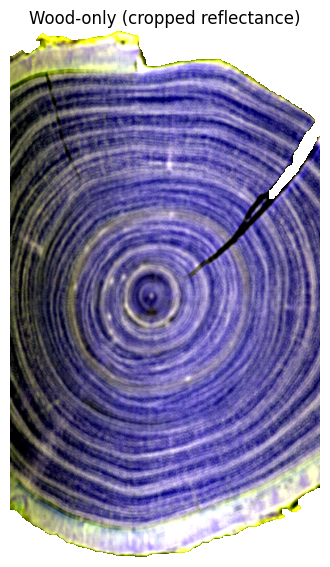

Saved training-ready pack -> cubes_out/wood_only_reflectance_pack.npz
Fields: reflect, radiance, wavs, wood_mask, rgb_quicklook, bbox, center_rc, rmax_px, band_indices, stats, white_spectrum


In [13]:
# Cell 12 — Wood-only crop + save a training-ready pack (radiance+reflectance+wavs+mask+stats+center)

# ---- helpers ----
def pick_bands_by_nm(wavs, targets_nm):
    return [int(np.argmin(np.abs(wavs - t))) for t in targets_nm]

def make_rgb(arr, bands):
    sub = arr[:, :, bands].astype(np.float32).copy()
    rgb = np.empty_like(sub)
    for k in range(3):
        ch = sub[:, :, k]
        vmin = np.nanpercentile(ch, 2)
        vmax = np.nanpercentile(ch, 98)
        rgb[:, :, k] = (ch - vmin) / (vmax - vmin + 1e-9)
    return np.clip(rgb, 0, 1)

def nanmeanstd(arr, mask2d):
    flat = arr[mask2d, :]
    mu = np.nanmean(flat, axis=0)
    sd = np.nanstd(flat, axis=0)
    return mu.astype(np.float32), sd.astype(np.float32)

# ---- 0) Inputs expected from previous cells ----
# reflect: (H,W,B) white-corrected reflectance
# cube   : (H,W,B) raw radiance (auto dark-corrected by camera)
# wavs   : (B,) wavelengths in nm
H, W, B = reflect.shape

# ---- 1) Build wood mask on a clean band (~1100 nm), keep largest component ----
b1100 = int(np.argmin(np.abs(wavs - 1100)))
band = np.nan_to_num(reflect[:, :, b1100])
band_s = gaussian(band, sigma=2, preserve_range=True)

t = threshold_otsu(band_s)
mask = band_s > t
mask = closing(mask, footprint_rectangle((5,5)))
mask = remove_small_objects(mask, min_size=5000)
mask = binary_fill_holes(mask)

lab = label(mask)
regs = regionprops(lab)
if not regs:
    raise RuntimeError("Wood mask not found—adjust thresholding.")
largest = max(regs, key=lambda r: r.area)
wood_mask = (lab == largest.label)

# ---- 2) Tight crop bbox + crop arrays ----
minr, minc, maxr, maxc = largest.bbox
print("Wood bbox (r0,c0,r1,c1):", (minr, minc, maxr, maxc))

reflect_wood = reflect[minr:maxr, minc:maxc, :].copy()
radiance_wood = cube[minr:maxr, minc:maxc, :].copy()
wood_mask_crop = wood_mask[minr:maxr, minc:maxc].copy()

# outside -> NaN for reflectance (keeps geometry while masking background)
reflect_wood[~wood_mask_crop] = np.nan

# ---- 3) Center inside crop (centroid of wood) & max usable radius (for later polar ops) ----
cy_local, cx_local = map(int, regionprops(label(wood_mask_crop))[0].centroid)
Rmax_local = int(distance_transform_edt(wood_mask_crop)[cy_local, cx_local])

# ---- 4) Useful band indices & per-band stats ----
b1200 = int(np.argmin(np.abs(wavs - 1200)))
b1730 = int(np.argmin(np.abs(wavs - 1730)))
b2100 = int(np.argmin(np.abs(wavs - 2100)))
b2330 = int(np.argmin(np.abs(wavs - 2330)))
band_indices = np.array([b1100, b1200, b1730, b2100, b2330], dtype=np.int32)

valid_mask = np.isfinite(reflect_wood).any(axis=2)
mu_reflect, sd_reflect   = nanmeanstd(reflect_wood, valid_mask)
mu_radiance, sd_radiance = nanmeanstd(radiance_wood, valid_mask)

# ---- 5) Cropped false-color quicklook (1700,1450,1100 nm) ----
bands_rgb = pick_bands_by_nm(wavs, [1700, 1450, 1100])
rgb_wood = make_rgb(reflect_wood, bands_rgb)

plt.figure(figsize=(4,8))
plt.imshow(rgb_wood); plt.title("Wood-only (cropped reflectance)"); plt.axis("off")
plt.show()

# ---- 6) White spectrum used (if available from earlier cells); otherwise save NaNs ----
if "Wspec" in globals():
    white_spec = np.asarray(Wspec, dtype=np.float32)
else:
    white_spec = np.full((B,), np.nan, dtype=np.float32)

# ---- 7) Save training-ready pack ----
os.makedirs("cubes_out", exist_ok=True)
pack_path = "cubes_out/wood_only_reflectance_pack.npz"
np.savez_compressed(
    pack_path,
    reflect=reflect_wood.astype(np.float32),
    radiance=radiance_wood.astype(np.float32),
    wavs=wavs.astype(np.float32),
    wood_mask=wood_mask_crop.astype(np.uint8),
    rgb_quicklook=rgb_wood.astype(np.float32),
    bbox=np.array([minr, minc, maxr, maxc], dtype=np.int32),
    center_rc=np.array([cy_local, cx_local], dtype=np.int32),
    rmax_px=np.array([Rmax_local], dtype=np.int32),
    band_indices=band_indices,
    mu_reflect=mu_reflect, sd_reflect=sd_reflect,
    mu_radiance=mu_radiance, sd_radiance=sd_radiance,
    white_spectrum=white_spec
)

# human-readable metadata sidecar
meta = {
    "shape_reflect": list(reflect_wood.shape),
    "shape_radiance": list(radiance_wood.shape),
    "bbox_rowcol": [int(minr), int(minc), int(maxr), int(maxc)],
    "center_local_rc": [int(cy_local), int(cx_local)],
    "rmax_local_px": int(Rmax_local),
    "band_indices": {"b1100": int(b1100), "b1200": int(b1200), "b1730": int(b1730),
                     "b2100": int(b2100), "b2330": int(b2330)},
    "rgb_bands_nm": [float(wavs[i]) for i in bands_rgb],
    "notes": "radiance is camera dark-corrected; reflectance = radiance / mean(white_patch)."
}
with open("cubes_out/wood_only_reflectance_pack.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved training-ready pack ->", pack_path)
print("Fields: reflect, radiance, wavs, wood_mask, rgb_quicklook, bbox, center_rc, rmax_px, band_indices, stats, white_spectrum")


In [14]:
# U1 — Prepare data matrix for unmixing (uses your cropped cube from Cell 12)
import numpy as np
import matplotlib.pyplot as plt

R = reflect_wood.copy()  # (Hc, Wc, B)
Hc, Wc, Bc = R.shape

# keep SWIR bands but drop deep water absorption troughs (often noisy)
keep = (wavs >= 1000) & (wavs <= 2400) & ~((wavs>=1350)&(wavs<=1450)) & ~((wavs>=1850)&(wavs<=1950))
Rk = R[:, :, keep]
w_k = wavs[keep]
Bk = Rk.shape[2]

# mask invalid pixels
valid = np.isfinite(Rk).all(axis=2)
Y = Rk[valid, :]              # (Npix, Bk) data matrix

# (optional) scale per band to unit variance for numerical stability
mu = np.nanmean(Y, axis=0);  sd = np.nanstd(Y, axis=0) + 1e-12
Yz = (Y - mu) / sd

print("Data:", Y.shape, "bands kept:", Bk)


Data: (225123, 219) bands kept: 219


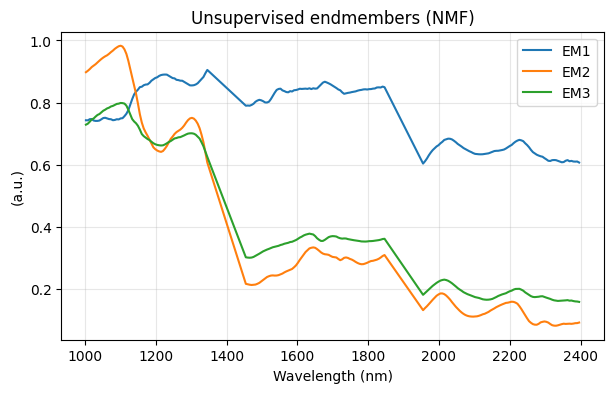

In [15]:
# U2 — Unsupervised NMF (K=3: earlywood, latewood, background)
from sklearn.decomposition import NMF

K = 3
nmf = NMF(n_components=K, init="nndsvda", max_iter=600, random_state=0)
# shift to positive for NMF (z-scored data can be negative)
Ypos = Yz - Yz.min(axis=0, keepdims=True)
A = nmf.fit_transform(Ypos)        # (Npix, K) abundances (non-negative)
E = nmf.components_                # (K, Bk) endmember “spectra” in transformed space

# Map endmembers back to reflectance-ish units for plotting
E_ref = (E + Yz.min(axis=0)) * sd + mu

# Visualize endmember curves
plt.figure(figsize=(7,4))
for k in range(K):
    plt.plot(w_k, E_ref[k], label=f'EM{k+1}')
plt.xlabel("Wavelength (nm)"); plt.ylabel("(a.u.)")
plt.title("Unsupervised endmembers (NMF)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


Latewood EM index: 1 Earlywood EM index: 0


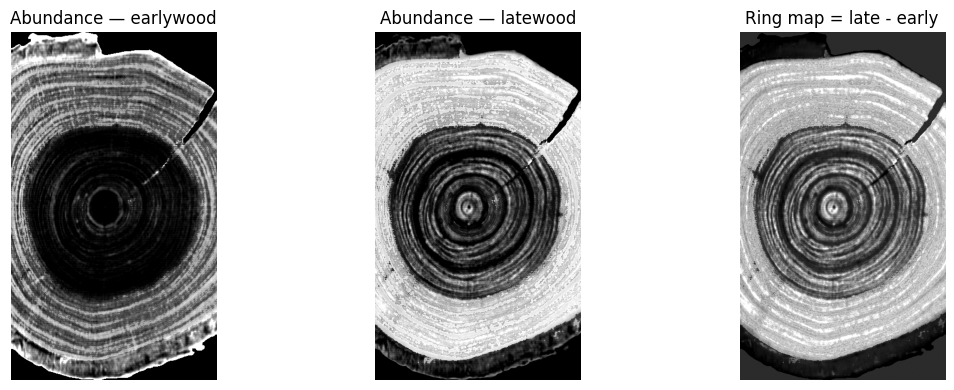

In [16]:
# U3 — Put abundance maps back into image shape and build a ring map
A_img = np.zeros((Hc, Wc, K), dtype=np.float32)
A_img[valid, :] = A

# Normalize abundances per pixel (optional)
A_sum = A_img.sum(axis=2, keepdims=True) + 1e-12
A_img = A_img / A_sum

# Heuristic: EM with *lower* mean reflectance across bands tends to be "dark latewood"
mean_E = E_ref.mean(axis=1)
idx_dark  = int(np.argmin(mean_E))
idx_light = int(np.argmax(mean_E))
print("Latewood EM index:", idx_dark, "Earlywood EM index:", idx_light)

A_dark  = A_img[:, :, idx_dark]
A_light = A_img[:, :, idx_light]

# Ring-enhancement map: latewood - earlywood
ring_map_unmix = A_dark - A_light

# Quicklook
def norm01(x):
    p2,p98 = np.nanpercentile(x,2), np.nanpercentile(x,98)
    return np.clip((x-p2)/(p98-p2+1e-12),0,1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(norm01(A_light), cmap="gray"); plt.title("Abundance — earlywood"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(norm01(A_dark),  cmap="gray"); plt.title("Abundance — latewood");  plt.axis("off")
plt.subplot(1,3,3); plt.imshow(norm01(ring_map_unmix), cmap="gray"); plt.title("Ring map = late - early"); plt.axis("off")
plt.tight_layout(); plt.show()


C:\Users\mubut0522\AppData\Local\Temp\ipykernel_35620\3171230177.py:58: RuntimeWarning: Mean of empty slice
  scores.append(np.nanmean(np.std(sect, axis=0)))
C:\Users\mubut0522\AppData\Local\Temp\ipykernel_35620\3171230177.py:64: RuntimeWarning: Mean of empty slice
  profile = np.nanmean(polar[:, sector[0]:sector[1]], axis=1)


[13_final] Rmax=360, sector=(152, 162), rings=15


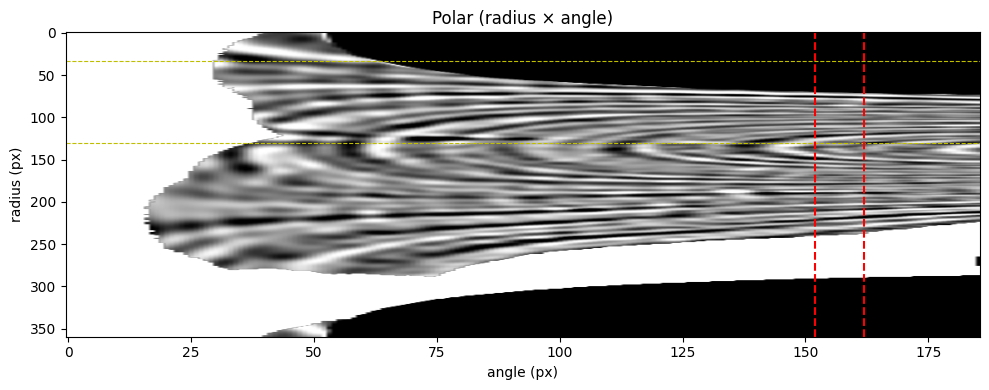

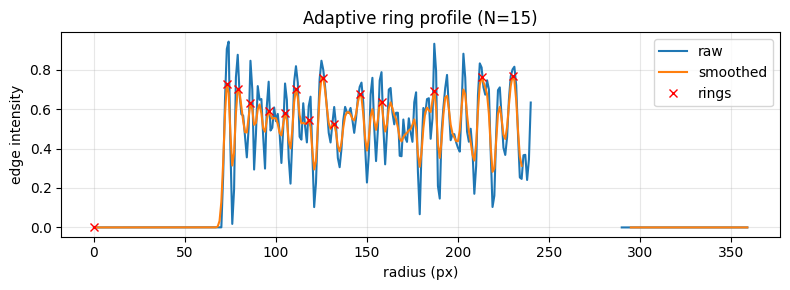

In [17]:
# Cell 13_final — build ring-enhanced map, unwrap to polar, auto-pick sector, adaptive peaks,
# and SAVE all artifacts + parameters for reproducibility.

import os, json, numpy as np, matplotlib.pyplot as plt
from skimage.filters import gaussian, laplace
from skimage.transform import warp_polar
from scipy.ndimage import distance_transform_edt
from scipy.signal import find_peaks

os.makedirs("rings_out", exist_ok=True)

# ---------- Parameters (log these for provenance) ----------
PARAMS = {
    "ratio_bands_nm": [1730, 1200],
    "log_sigma": 3.0,         # Gaussian sigma before Laplacian
    "norm_percentiles": [2, 98],
    "sector_width_cols": 10,  # polar angle width (columns)
    "contrast_band_pct": [0.18, 0.70],  # r_lo..r_hi as fractions of max radius
    # Adaptive peak zones: (start_px, end_px, distance, prominence)
    "peak_zones": [
        [0,   45,   3,  0.0015],  # inner: lenient
        [45,  130,  6,  0.0040],  # mid
        [130, 9999, 12, 0.0090],  # outer
    ],
    "profile_smooth_sigma": 1.2
}

# ---------- Helpers ----------
def norm_img(img, p=(2,98)):
    vmin, vmax = np.nanpercentile(img, p[0]), np.nanpercentile(img, p[1])
    return np.clip((img - vmin) / (vmax - vmin + 1e-9), 0, 1)

EPS = 1e-6
Hc, Wc, Bc = reflect_wood.shape

# ---------- 1) Ring-enhanced base (1730/1200 → LoG → normalize) ----------
ratio = reflect_wood[:, :, b1730] / (reflect_wood[:, :, b1200] + EPS)
ring_base = laplace(gaussian(ratio, sigma=PARAMS["log_sigma"]))
ring_base_n = norm_img(ring_base, p=PARAMS["norm_percentiles"])

# ---------- 2) Radius limit from wood mask ----------
dist_local = distance_transform_edt(wood_mask_crop)
Rmax = int(dist_local[cy_local, cx_local])

# ---------- 3) Polar unwrap ----------
polar = warp_polar(ring_base_n, center=(cx_local, cy_local), radius=Rmax, scaling='linear')
R, T = polar.shape

# choose radius band for sector scoring
r_lo = max(8, int(Rmax * PARAMS["contrast_band_pct"][0]))
r_hi = max(r_lo+25, int(Rmax * PARAMS["contrast_band_pct"][1]))

# auto-pick best angle sector (highest angular contrast)
W = PARAMS["sector_width_cols"]
scores = []
for c in range(0, max(1, T - W)):
    sect = polar[r_lo:r_hi, c:c+W]
    scores.append(np.nanmean(np.std(sect, axis=0)))
scores = np.asarray(scores)
c_best = int(np.nanargmax(scores))
sector = (c_best, min(T, c_best+W))

# ---------- 4) 1-D profile over sector; smooth ----------
profile = np.nanmean(polar[:, sector[0]:sector[1]], axis=1)
profile_s = gaussian(profile, sigma=PARAMS["profile_smooth_sigma"])

# ---------- 5) Adaptive peak detection ----------
peaks = []
for z in PARAMS["peak_zones"]:
    z0, z1, dist, prom = z
    z1 = min(z1, R)
    if z1 <= z0+2: 
        continue
    pk, _ = find_peaks(profile_s[z0:z1], distance=dist, prominence=prom)
    peaks.extend((pk + z0).tolist())
peaks = np.unique(np.asarray(peaks, dtype=int))

# if inner peak still missing, force the strongest within first 25 px
if (peaks.size == 0) or (peaks[0] > 20):
    first_best = int(np.argmax(profile_s[:min(25, R)]))
    peaks = np.insert(peaks, 0, first_best)

N = int(peaks.size)
print(f"[13_final] Rmax={R}, sector={sector}, rings={N}")

# ---------- 6) Save artifacts ----------
# Polar image with sector & band lines
plt.figure(figsize=(10,4))
plt.imshow(polar, aspect='auto', cmap='gray')
plt.axhline(r_lo, color='y', ls='--', lw=0.8); plt.axhline(r_hi, color='y', ls='--', lw=0.8)
plt.axvline(sector[0], color='r', ls='--');   plt.axvline(sector[1], color='r', ls='--')
plt.title("Polar (radius × angle)")
plt.xlabel("angle (px)"); plt.ylabel("radius (px)")
plt.tight_layout(); plt.savefig("rings_out/polar_map.png", dpi=200); plt.show()

# Profile plot with peaks
plt.figure(figsize=(8,3))
plt.plot(profile, label="raw"); plt.plot(profile_s, label="smoothed")
plt.plot(peaks, profile_s[peaks], "rx", label="rings")
plt.xlabel("radius (px)"); plt.ylabel("edge intensity")
plt.title(f"Adaptive ring profile (N={N})")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("rings_out/ring_profile.png", dpi=200); plt.show()

# Save radii + params for full provenance
np.save("rings_out/ring_radii_px.npy", peaks)
meta = {
    "center_local_rc": [int(cy_local), int(cx_local)],
    "Rmax": int(Rmax),
    "sector_cols": list(map(int, sector)),
    "r_band_px": [int(r_lo), int(r_hi)],
    "params": PARAMS
}
with open("rings_out/ring_detection_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# Export a CSV with just index + radius (years added in Cell 14_final if you set bark_year)
import pandas as pd
pd.DataFrame({"ring_index": np.arange(1, N+1), "radius_px": peaks}).to_csv(
    "rings_out/rings_detected.csv", index=False
)

# Keep for next cell
ring_radii_px = peaks


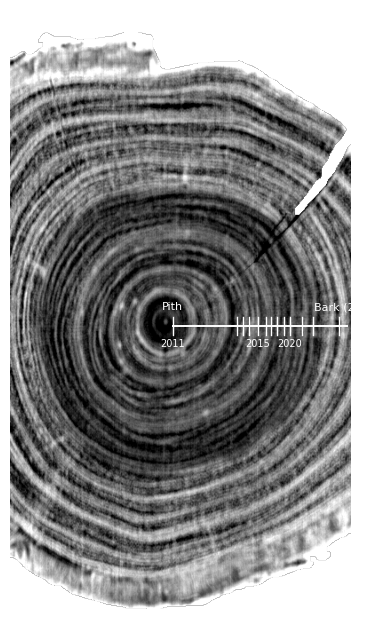

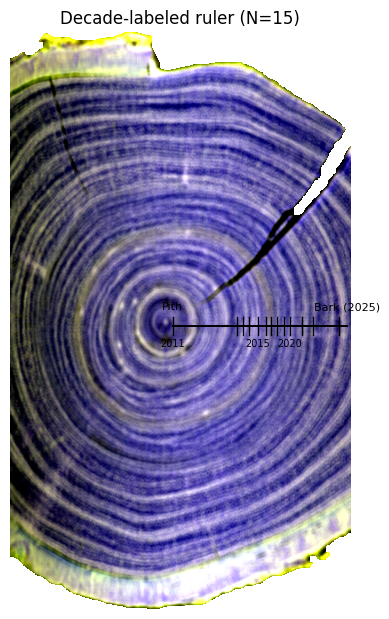

Saved:
 - rings_out/overlay_gray_decades.png
 - rings_out/overlay_rgb_decades.png
 - rings_out/rings_detected.csv
 - rings_out/rings_detected_with_years.csv


In [18]:
# Cell 14_final — Presentation overlays + years + GT line mask

import os, numpy as np, matplotlib.pyplot as plt, pandas as pd

os.makedirs("rings_out", exist_ok=True)

# ---- CONFIG ----
bark_year = 2025            # set to your known bark year
label_every_years = 5       # decades
tick_len = 10               # tick half-height in px
line_w = 1.4                # baseline width in plots

# Backgrounds
def norm_img(img, p=(2,98)):
    vmin, vmax = np.nanpercentile(img, p[0]), np.nanpercentile(img, p[1])
    return np.clip((img - vmin) / (vmax - vmin + 1e-9), 0, 1)

bg_gray = norm_img(reflect_wood[:, :, b1730] / (reflect_wood[:, :, b1200] + 1e-6))  # same ratio as profile
bg_rgb  = rgb_wood.copy()

radii = np.asarray(ring_radii_px, dtype=int)
N = int(radii.size)
years = [bark_year - (N - i) for i in range(1, N+1)]  # pith oldest -> bark=bark_year

y0, x0 = int(cy_local), int(cx_local)
x_last = min(bg_gray.shape[1]-5, x0 + int(radii[-1]))

def draw_ruler(ax, is_gray=True):
    color = "white" if is_gray else "black"
    ax.plot([x0, x_last], [y0, y0], '-', color=color, linewidth=line_w)
    for i, (r, yr) in enumerate(zip(radii, years), start=1):
        x = x0 + int(r)
        if 0 <= x < bg_gray.shape[1]:
            ax.plot([x, x], [y0-tick_len, y0+tick_len], '-', color=color, linewidth=1)
            if yr % label_every_years == 0 or i in (1, N):
                ax.text(x, y0+tick_len+4, str(yr), ha="center", va="top", fontsize=7, color=color)
    ax.text(x0, y0-(tick_len+6), "Pith", ha="center", va="bottom", fontsize=8, color=color)
    ax.text(x_last, y0-(tick_len+6), f"Bark ({bark_year})", ha="center", va="bottom", fontsize=8, color=color)

# 1) Grayscale overlay
fig, ax = plt.subplots(figsize=(4,8))
ax.imshow(bg_gray, cmap="gray"); ax.axis("off")
draw_ruler(ax, is_gray=True)
ax.set_title(f"Decade-labeled ruler (N={N})", color="white")
plt.tight_layout(); plt.savefig("rings_out/overlay_gray_decades.png", dpi=200, bbox_inches="tight"); plt.show()

# 2) RGB overlay (use black ink for contrast)
fig, ax = plt.subplots(figsize=(4,8))
ax.imshow(bg_rgb); ax.axis("off")
draw_ruler(ax, is_gray=False)
ax.set_title(f"Decade-labeled ruler (N={N})")
plt.tight_layout(); plt.savefig("rings_out/overlay_rgb_decades.png", dpi=200, bbox_inches="tight"); plt.show()

# 3) CSV with years
pd.DataFrame({"ring_index": np.arange(1, N+1), "radius_px": radii, "year": years}).to_csv(
    "rings_out/rings_detected_with_years.csv", index=False
)

print("Saved:")
print(" - rings_out/overlay_gray_decades.png")
print(" - rings_out/overlay_rgb_decades.png")
print(" - rings_out/rings_detected.csv")
print(" - rings_out/rings_detected_with_years.csv")

# 4) GT line mask (binary, same size as crop) — ruler ticks only
gt_mask = np.zeros(bg_gray.shape, dtype=np.uint8)
gt_mask[y0, x0:x_last+1] = 1  # baseline
for r in radii:
    x = x0 + int(r)
    if 0 <= x < gt_mask.shape[1]:
        gt_mask[max(0,y0-tick_len):min(gt_mask.shape[0],y0+tick_len+1), x] = 1
np.save("rings_out/gt_ruler_mask.npy", gt_mask)
